In [1]:
import sys
sys.path.append('..')
import torch
import torch.nn as nn
import torch.optim as optim
from modules.models import *
import torchvision
from torchvision import models
import numpy as np
from torchvision import transforms
from torchvision.transforms import Compose
import utils.transform as transf
from torch.utils.data import DataLoader
from utils.utils import bbox_collate, data2target,MixedRandomSampler
import yaml
import os
import json
import copy
from PIL import Image
from dataset.dataset import MedicalBboxDataset
from dataset.make_dloader import make_data
import time
import collections
from utils.anchor import make_anchor
from torchvision.ops import nms

In [2]:
oicr = resnet_rpn(3,pretrained=False)
#oicr.load_state_dict(torch.load(f"/data/unagi0/masaoka/wsod/model/oicr/Retina_rpn4warmup1e-05_0_1.pt"))
oicr.cuda()
opt = optim.RMSprop(oicr.parameters(), lr = 1e-5, weight_decay=5e-4, momentum=0.9)

In [3]:
dl_t, _, dl_v, _, _ = make_data(batchsize=2,iteration=100,val=0,p_path=0)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
creating index...
index created!
creating index...
index created!
save complete!
creating index...
index created!
save complete!
creating index...
index created!
save complete!
creating index...
index created!
save complete!
creating index...
index created!
creating index...
index created!


In [4]:
p_box = make_anchor()

In [5]:
for epoch in range(1):
    for i, data in enumerate(dl_v,1):
        opt.zero_grad()
        labels, n, t, v, u= data2target(data)
        labels = labels.unsqueeze(1).unsqueeze(2).cuda().float() # bs, 1, 1, num_class
        rois = [p_box.cuda().float() for _ in range(labels.shape[0])]
        n = p_box.shape[0]
        rois = torch.stack(rois, dim=0) 
        rois = rois.unsqueeze(1) #bs, 1, n, 4
        output, loss,m,l1,l2,l3,retina,rpn = oicr(data["img"].cuda().float(), labels, rois,n)
        ld = retina/5
        loss = m+l1+l2+l3+retina+rpn
        loss = loss.mean()
        loss.backward()
        opt.step()

tensor([[[0.5098],
         [0.3657],
         [0.3035],
         ...,
         [0.4279],
         [0.5706],
         [0.5973]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0', grad_fn=<CatBackward>)
tensor([[[0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         ...,
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0', grad_fn=<CatBackward>)
tensor([[[0.4048],
         [0.3292],
         [0.2182],
         ...,
         [0.3342],
         [0.6341],
         [0.8044]]]

/opt/conda/conda-bld/pytorch_1587428132279/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


tensor([[[0.2194],
         [0.2203],
         [0.2498],
         ...,
         [0.3845],
         [0.3269],
         [0.6922]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0012,  0.0027, -0.0262,  0.0262],
         [-0.0022, -0.0042, -0.0306,  0.0036],
         [-0.0021, -0.0123, -0.0014,  0.0312],
         ...,
         [-0.0445,  0.0008,  0.0445, -0.0445],
         [-0.0445,  0.0008, -0.0445, -0.0445],
         [ 0.0221,  0.0032,  0.0613,  0.0369]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0082, 0.0068, 0.0068],
         [0.0084, 0.0068, 0.0068],
         [0.0084, 0.0068, 0.0068],
         ...,
         [0.0115, 0.0082, 0.0082],
         [0.0115, 0.0082, 0.0082],
         [0.0121, 0.0082, 0.0082]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0002, -0.0472, -0.1325,  0.1325],
         [ 0.0062, -0.0157, -0.1476,  0.0734],
         [-0.0168, -0.0445, -0.0471,  0.1517],
         ...,
         [-0.1252, -0.0238,  0.1252, -0.1252],
         [-0.1252

tensor([[[0.0069],
         [0.0241],
         [0.0048],
         ...,
         [0.0018],
         [0.0019],
         [0.0017]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0737, -0.4296, -0.7782,  0.9325],
         [-0.0202, -0.3159, -0.5438,  0.2634],
         [ 0.1021, -0.1488, -0.2611,  0.6366],
         ...,
         [-0.2072,  0.2151,  0.7919, -0.4859],
         [-0.3133, -0.1203,  0.1781, -0.8663],
         [ 0.0495,  0.1026,  1.0077, -0.0979]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0075, 0.0048, 0.0048],
         [0.0080, 0.0048, 0.0048],
         [0.0079, 0.0048, 0.0048],
         ...,
         [0.0059, 0.0041, 0.0041],
         [0.0071, 0.0041, 0.0041],
         [0.0080, 0.0041, 0.0041]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.0500, -0.0662, -0.5193,  0.6358],
         [ 0.1768, -0.0361, -0.4590,  0.2432],
         [ 0.1671, -0.0477, -0.1605,  0.6001],
         ...,
         [-0.1931,  0.0890,  0.5479, -0.3914],
         [-0.1477

tensor([[[1.3017e-03],
         [6.0537e-03],
         [1.5064e-03],
         ...,
         [2.0977e-07],
         [1.8334e-06],
         [2.8457e-07]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.3380, -0.8853, -0.8884,  1.6248],
         [ 0.1122, -0.3010, -0.7774,  0.6336],
         [-0.2112, -0.1469, -0.8001,  1.0538],
         ...,
         [ 0.0883,  0.2090,  2.5517, -1.0416],
         [-0.1936, -0.2752,  2.0226, -2.5040],
         [-0.3240, -0.1508,  3.0081, -1.5418]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0084, 0.0042, 0.0042],
         [0.0095, 0.0042, 0.0042],
         [0.0088, 0.0042, 0.0042],
         ...,
         [0.0071, 0.0038, 0.0038],
         [0.0085, 0.0038, 0.0038],
         [0.0092, 0.0038, 0.0038]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.1242, -0.0288, -0.3284,  0.4270],
         [ 0.1440,  0.0235, -0.2884,  0.2199],
         [ 0.0804,  0.0498, -0.1303,  0.3500],
         ...,
         [-0.1386, -0.0077,  0.4562, -0.

tensor([[[5.5520e-05],
         [5.3630e-04],
         [2.0236e-04],
         ...,
         [1.8326e-11],
         [3.3946e-09],
         [1.2841e-10]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 4.5607e-01, -8.7977e-01, -5.3671e-01,  2.7117e+00],
         [ 1.9138e-01, -1.6184e-01, -1.0712e+00,  1.4735e+00],
         [-4.1672e-03, -2.8159e-01, -1.5283e+00,  1.2246e+00],
         ...,
         [ 8.0212e-01, -2.3831e-01,  3.6554e+00, -4.7843e-01],
         [ 7.1187e-01, -4.1009e-01,  4.2138e+00, -2.6620e+00],
         [-8.9300e-01, -1.3584e-01,  3.7771e+00, -3.3558e+00]]],
       device='cuda:0', grad_fn=<CatBackward>)
tensor([[[0.0062, 0.0022, 0.0022],
         [0.0089, 0.0022, 0.0022],
         [0.0130, 0.0022, 0.0022],
         ...,
         [0.0072, 0.0022, 0.0022],
         [0.0061, 0.0022, 0.0022],
         [0.0091, 0.0022, 0.0022]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.2429, -0.0866, -0.2055,  0.7764],
         [ 0.1392,  0.0391, -0.4649,  0.6871],
     

tensor([[[1.3879e-05],
         [1.9776e-04],
         [7.9841e-05],
         ...,
         [1.2587e-14],
         [2.2175e-11],
         [6.0689e-13]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.4578, -0.5579, -0.5948,  3.1106],
         [ 0.0341, -0.0848, -1.0651,  1.7689],
         [ 0.1329, -0.3844, -1.5802,  1.1748],
         ...,
         [ 0.6365, -0.9339,  4.7597,  0.1256],
         [ 0.7787, -0.6984,  5.2631, -2.7473],
         [-0.6817,  0.5597,  3.9685, -4.0165]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0073, 0.0015, 0.0015],
         [0.0073, 0.0015, 0.0015],
         [0.0054, 0.0015, 0.0015],
         ...,
         [0.0015, 0.0012, 0.0012],
         [0.0050, 0.0012, 0.0012],
         [0.0066, 0.0012, 0.0012]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.1498,  0.0788, -0.4973,  0.8525],
         [ 0.0867,  0.2641, -0.4666,  0.6601],
         [ 0.4071,  0.3384, -0.6381,  0.5850],
         ...,
         [-0.4373, -0.1189,  0.9008, -0.

tensor([[[1.7012e-05],
         [1.1126e-04],
         [8.2573e-05],
         ...,
         [1.3065e-12],
         [1.5633e-10],
         [9.4620e-12]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.2747, -0.4000, -0.6404,  3.3167],
         [-0.2672, -0.1962, -1.0070,  1.7497],
         [-0.0358, -0.4103, -1.5381,  1.1472],
         ...,
         [ 0.3641, -0.9330,  4.4276,  0.0293],
         [ 0.3345, -0.8301,  4.8107, -2.6079],
         [-0.2272,  0.7234,  3.6539, -3.1765]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0034, 0.0022, 0.0022],
         [0.0050, 0.0022, 0.0022],
         [0.0044, 0.0022, 0.0022],
         ...,
         [0.0004, 0.0016, 0.0016],
         [0.0023, 0.0016, 0.0016],
         [0.0036, 0.0016, 0.0016]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.1120,  0.1267, -0.4727,  0.5784],
         [ 0.0696,  0.0520, -0.2866,  0.0145],
         [ 0.0538,  0.0612, -0.2673,  0.2967],
         ...,
         [-0.0677,  0.0558,  0.7220, -0.

tensor([[[2.9543e-05],
         [1.2728e-04],
         [2.4823e-04],
         ...,
         [4.8807e-11],
         [4.2669e-09],
         [4.8121e-10]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.0117, -0.3189, -0.7213,  2.9166],
         [-0.4706, -0.1807, -0.9117,  1.5212],
         [-0.1613, -0.3579, -1.3193,  1.2892],
         ...,
         [ 0.0998, -0.3090,  3.8041, -0.5800],
         [-0.2432, -0.4079,  4.1474, -2.8841],
         [ 0.0578, -0.0609,  2.9203, -2.1157]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0052, 0.0035, 0.0035],
         [0.0089, 0.0035, 0.0035],
         [0.0121, 0.0035, 0.0035],
         ...,
         [0.0028, 0.0033, 0.0033],
         [0.0073, 0.0033, 0.0033],
         [0.0107, 0.0033, 0.0033]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.1262,  0.0811, -0.3676,  0.4921],
         [ 0.0568,  0.0975, -0.2050,  0.0099],
         [ 0.0073,  0.0801, -0.1563,  0.3751],
         ...,
         [-0.0180, -0.0262,  0.8069, -0.

tensor([[[2.8929e-05],
         [1.8588e-04],
         [6.9382e-05],
         ...,
         [9.1450e-11],
         [1.1852e-08],
         [1.1836e-09]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0979, -0.5385, -1.1352,  2.7539],
         [-0.2564, -0.1433, -0.9657,  1.4180],
         [-0.1218, -0.2272, -1.1353,  1.3224],
         ...,
         [-0.1832,  0.2182,  4.0949, -0.9545],
         [-0.5062, -0.1016,  4.0688, -3.5333],
         [ 0.4516, -0.2125,  2.2574, -1.7492]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0050, 0.0040, 0.0040],
         [0.0082, 0.0040, 0.0040],
         [0.0098, 0.0040, 0.0040],
         ...,
         [0.0060, 0.0045, 0.0045],
         [0.0091, 0.0045, 0.0045],
         [0.0109, 0.0045, 0.0045]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-1.4689e-01,  1.1416e-01, -5.2819e-01,  6.5417e-01],
         [ 1.5409e-01,  3.5038e-01, -3.0757e-01,  2.4051e-01],
         [ 1.4385e-01,  3.4644e-01, -3.1944e-01,  5.7209e-01],
      

tensor([[[4.6291e-05],
         [2.3142e-04],
         [1.5282e-04],
         ...,
         [4.5036e-12],
         [8.9394e-10],
         [7.2985e-11]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0824, -0.7973, -1.2357,  2.3509],
         [-0.1119, -0.2616, -0.9895,  1.2472],
         [-0.0461, -0.0331, -0.8892,  0.9865],
         ...,
         [-0.2839,  0.6913,  4.9245, -1.1412],
         [-0.6128, -0.1520,  4.7277, -4.4538],
         [ 0.2632,  0.6726,  2.2217, -1.3613]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0058, 0.0040, 0.0040],
         [0.0091, 0.0040, 0.0040],
         [0.0105, 0.0040, 0.0040],
         ...,
         [0.0076, 0.0041, 0.0041],
         [0.0090, 0.0041, 0.0041],
         [0.0117, 0.0041, 0.0041]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0744, -0.0819, -0.4780,  0.4391],
         [ 0.1132,  0.0507, -0.3196,  0.1266],
         [-0.0360,  0.0655, -0.1102,  0.3464],
         ...,
         [ 0.2291,  0.1852,  0.8098, -0.

tensor([[[4.9243e-05],
         [1.6683e-04],
         [1.0369e-04],
         ...,
         [2.5401e-12],
         [1.0932e-09],
         [6.1620e-11]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 3.0575e-03, -9.4134e-01, -1.3933e+00,  2.4807e+00],
         [-1.3991e-01, -3.2313e-01, -1.1148e+00,  1.3542e+00],
         [-3.7127e-02,  1.5525e-01, -9.2323e-01,  8.1274e-01],
         ...,
         [-2.3913e-01,  1.0637e+00,  5.0910e+00, -1.2241e+00],
         [-6.4587e-01, -1.9668e-01,  4.9498e+00, -4.8021e+00],
         [ 8.2750e-02,  1.3699e+00,  1.9571e+00, -7.3251e-01]]],
       device='cuda:0', grad_fn=<CatBackward>)
tensor([[[0.0056, 0.0036, 0.0036],
         [0.0076, 0.0036, 0.0036],
         [0.0095, 0.0036, 0.0036],
         ...,
         [0.0074, 0.0043, 0.0043],
         [0.0080, 0.0043, 0.0043],
         [0.0102, 0.0043, 0.0043]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0695, -0.1368, -0.3947,  0.4131],
         [ 0.1377, -0.0801, -0.3026,  0.0221],
     

tensor([[[1.1630e-05],
         [1.2653e-04],
         [3.8465e-05],
         ...,
         [4.3688e-12],
         [1.6035e-09],
         [1.2949e-10]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[ 0.0096, -1.0854, -1.6549,  2.6188],
         [-0.1773, -0.4550, -1.3138,  1.4193],
         [-0.0645, -0.0293, -0.8354,  0.6676],
         ...,
         [-0.5447,  1.1044,  5.1150, -1.4500],
         [-0.7058, -0.2236,  4.9761, -4.8887],
         [-0.0782,  1.4344,  1.9413, -0.4294]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0060, 0.0030, 0.0030],
         [0.0080, 0.0030, 0.0030],
         [0.0114, 0.0030, 0.0030],
         ...,
         [0.0082, 0.0038, 0.0038],
         [0.0085, 0.0038, 0.0038],
         [0.0106, 0.0038, 0.0038]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0931, -0.0291, -0.4023,  0.3416],
         [ 0.0545, -0.0228, -0.2912, -0.0321],
         [-0.1518, -0.0977, -0.3267,  0.2300],
         ...,
         [ 0.1702,  0.3124,  0.7195, -0.

tensor([[[5.8187e-06],
         [1.0992e-04],
         [2.5693e-05],
         ...,
         [2.5131e-12],
         [1.0035e-09],
         [7.6327e-11]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.0381, -1.2440, -1.8170,  2.7751],
         [-0.1769, -0.4904, -1.4611,  1.5576],
         [-0.0553, -0.1512, -0.8122,  0.6180],
         ...,
         [-1.0132,  1.1125,  5.5377, -1.5690],
         [-1.0197, -0.1142,  5.1927, -4.8704],
         [-0.1655,  1.0479,  2.2651, -0.1910]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[[0.0046, 0.0027, 0.0027],
         [0.0064, 0.0027, 0.0027],
         [0.0086, 0.0027, 0.0027],
         ...,
         [0.0062, 0.0036, 0.0036],
         [0.0071, 0.0036, 0.0036],
         [0.0100, 0.0036, 0.0036]]], device='cuda:0', grad_fn=<CatBackward>) tensor([[[-0.1723, -0.0315, -0.3928,  0.3994],
         [-0.0078, -0.0937, -0.3431, -0.0245],
         [-0.1933, -0.1575, -0.2939,  0.2897],
         ...,
         [ 0.1936,  0.4982,  0.9193, -0.

KeyboardInterrupt: 

In [6]:
for epoch in range(1):
    for i, data in enumerate(dl_v,1):
        opt.zero_grad()
        labels, n, t, v, u= data2target(data)
        labels = labels.unsqueeze(1).unsqueeze(2).cuda().float() # bs, 1, 1, num_class
        rois = [p_box.cuda().float() for _ in range(labels.shape[0])]
        n = p_box.shape[0]
        rois = torch.stack(rois, dim=0) 
        rois = rois.unsqueeze(1) #bs, 1, n, 4
        rois = oicr(data["img"].cuda().float(), labels, rois,n)
        break
rois = rois[0]

In [16]:
r = rois[0]#[(rois>400).any(1),:]

In [17]:
r

tensor([[5.0447e-08, 2.7185e-07, 9.4084e-10, 2.3799e-09],
        [4.0489e-08, 1.0794e-07, 8.1084e-10, 1.6032e-09],
        [5.1988e-08, 9.7847e-08, 5.6376e-10, 1.3556e-09],
        ...,
        [1.5419e-10, 1.8515e-08, 1.5821e-10, 3.7198e-07],
        [3.3908e-11, 1.5548e-05, 5.6575e-10, 2.6095e-09],
        [1.3073e-09, 7.7401e-08, 1.5474e-09, 6.8900e-08]], device='cuda:0',
       grad_fn=<SelectBackward>)

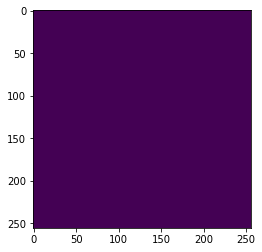

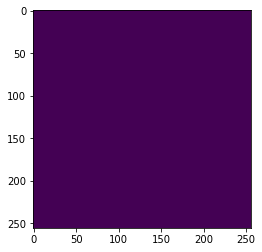

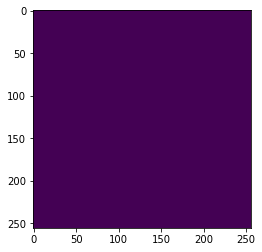

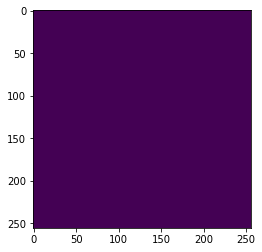

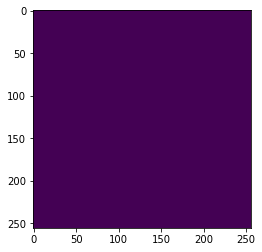

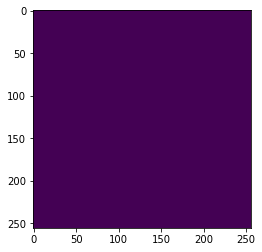

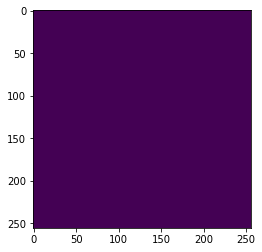

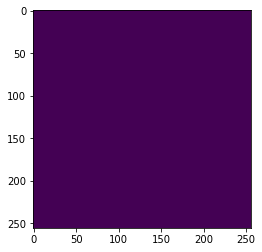

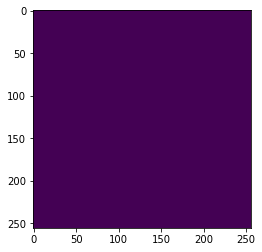

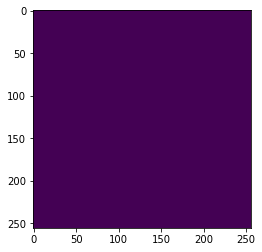

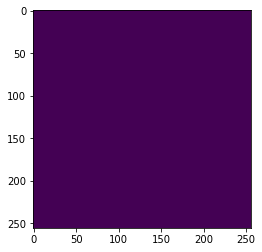

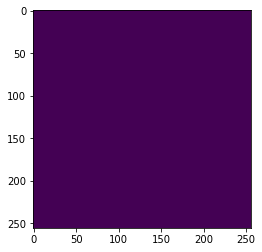

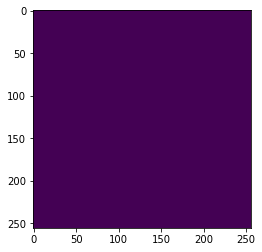

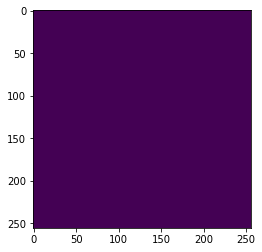

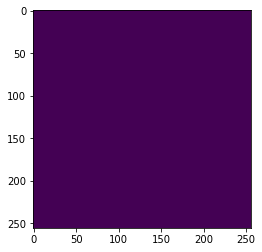

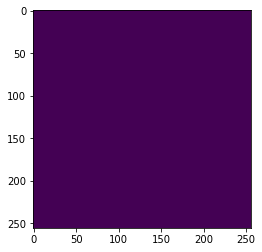

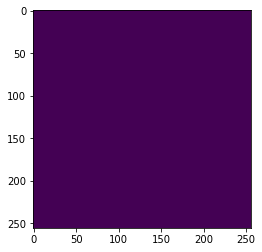

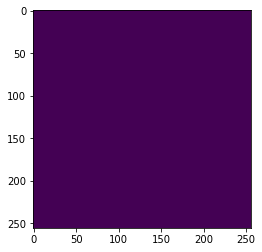

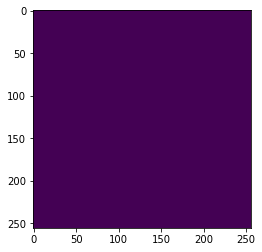

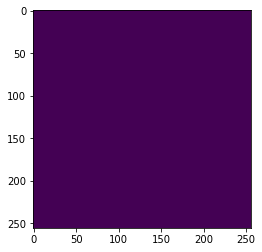

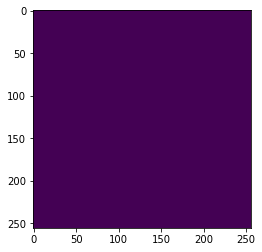

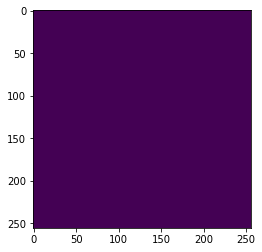

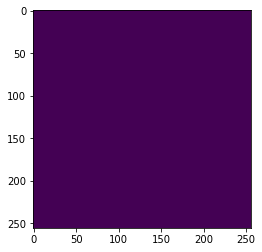

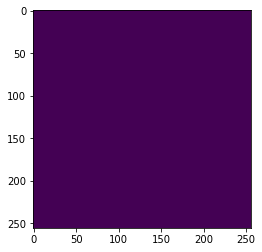

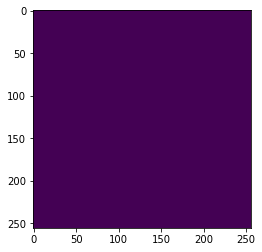

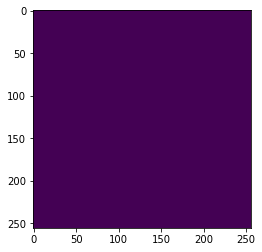

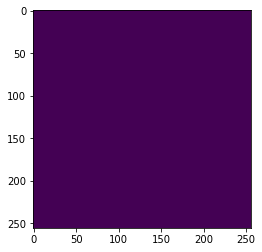

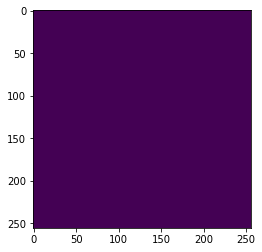

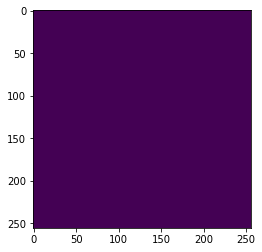

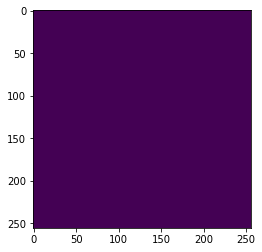

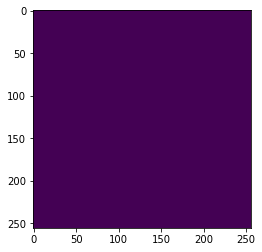

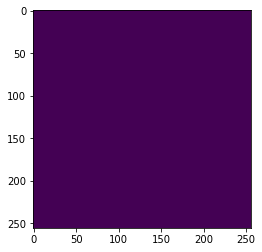

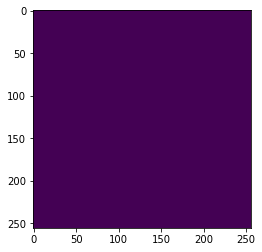

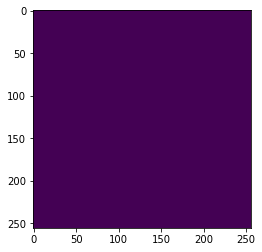

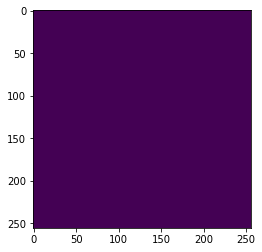

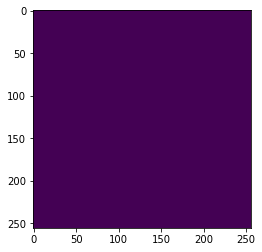

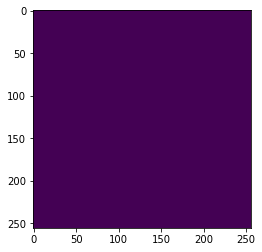

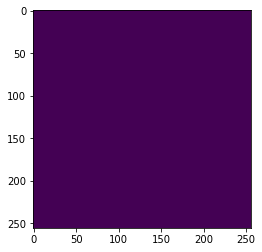

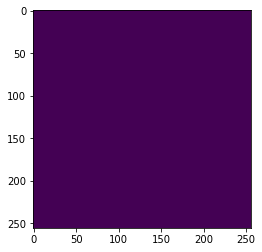

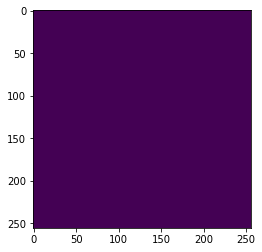

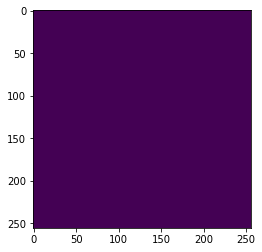

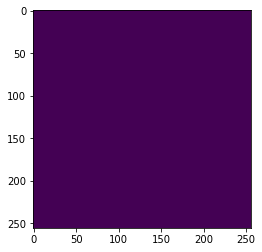

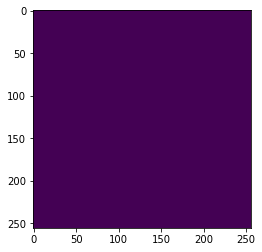

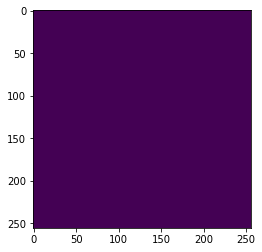

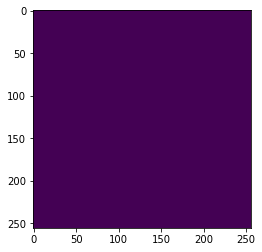

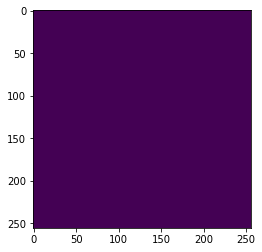

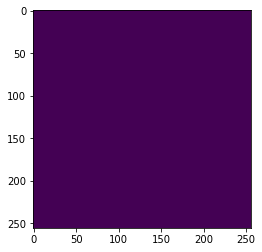

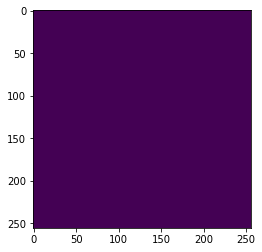

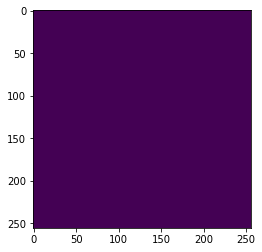

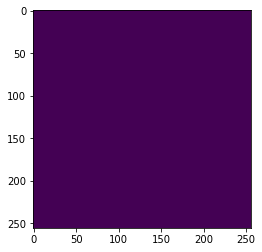

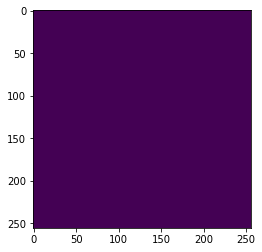

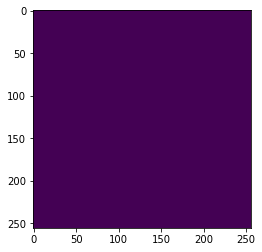

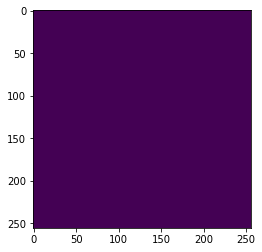

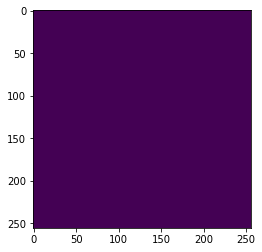

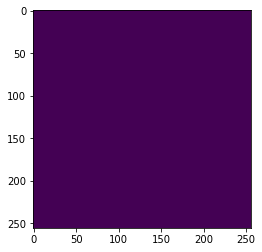

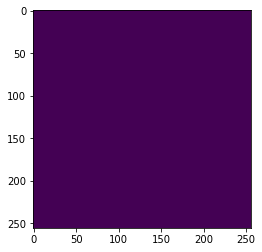

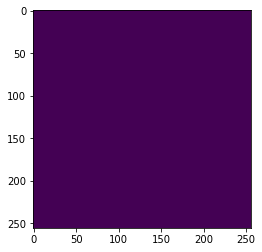

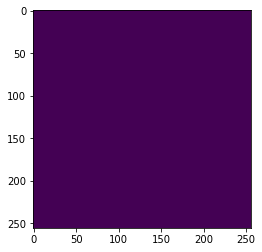

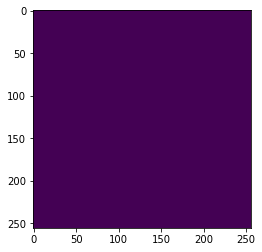

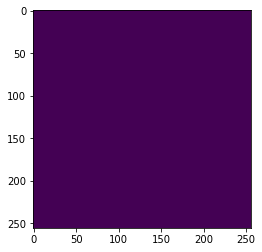

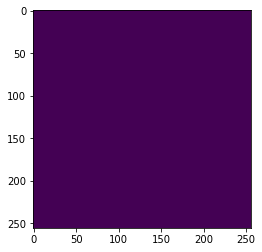

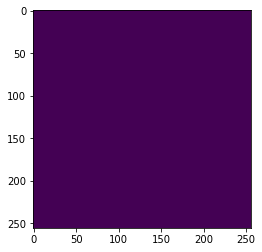

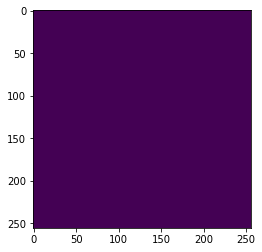

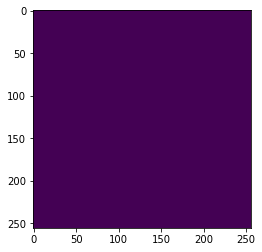

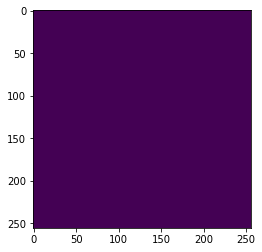

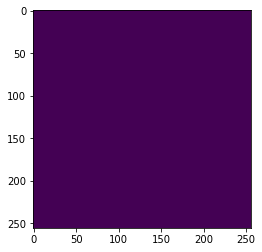

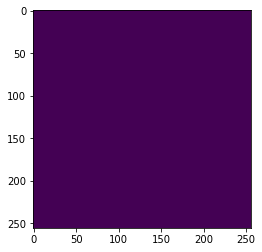

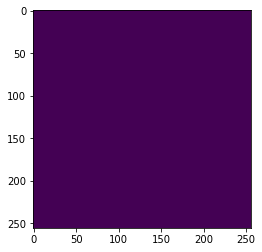

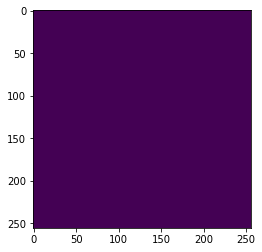

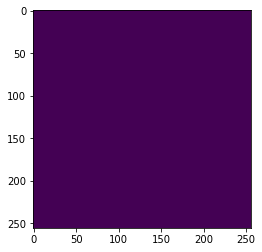

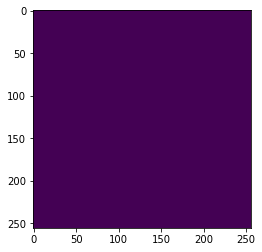

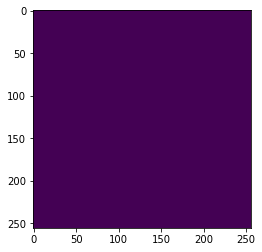

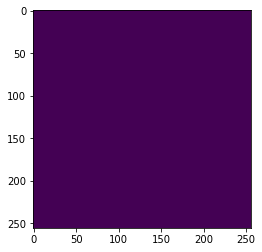

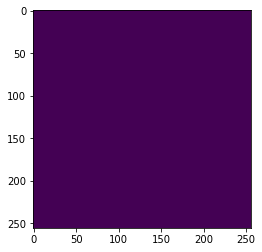

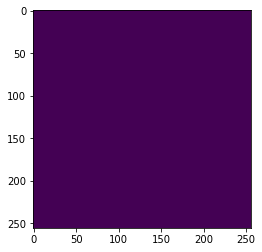

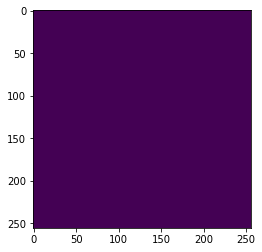

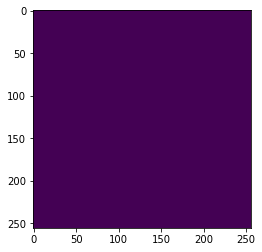

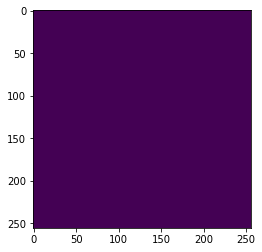

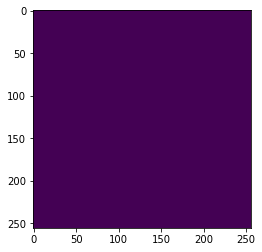

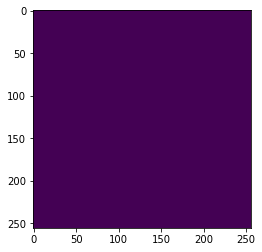

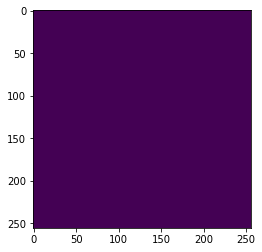

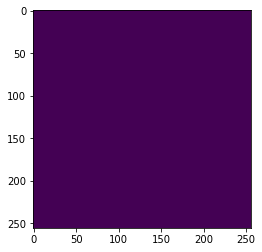

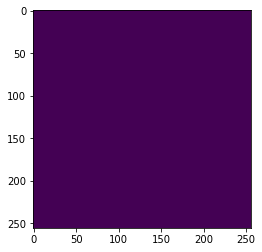

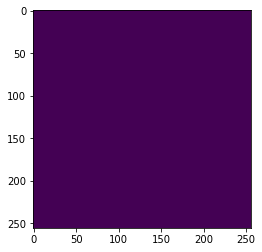

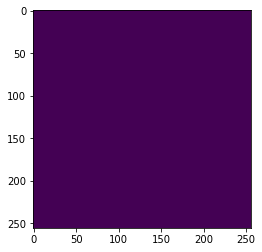

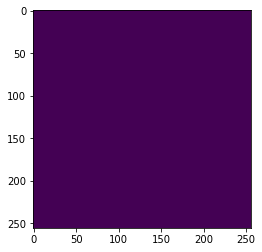

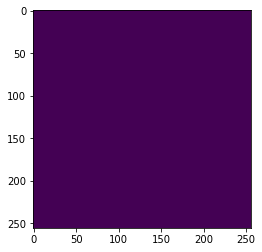

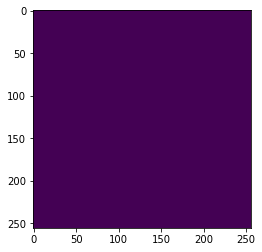

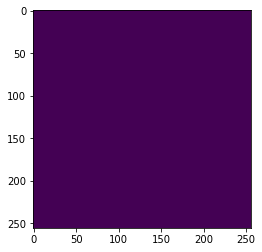

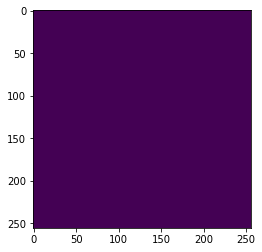

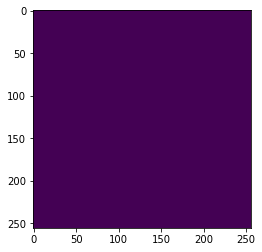

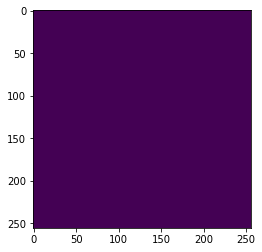

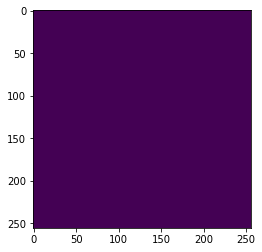

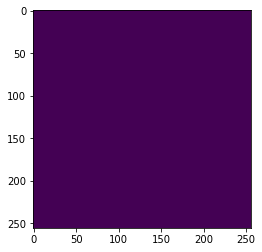

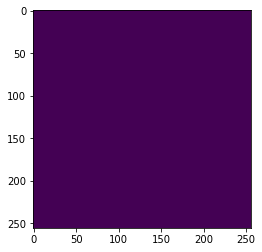

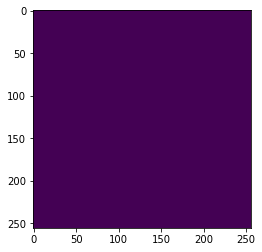

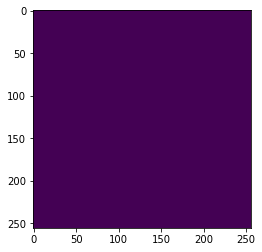

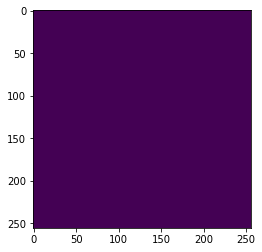

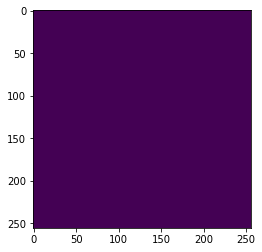

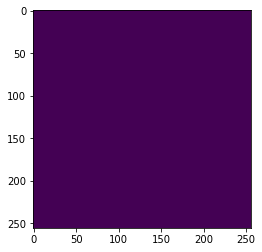

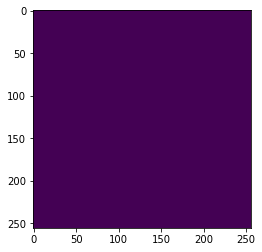

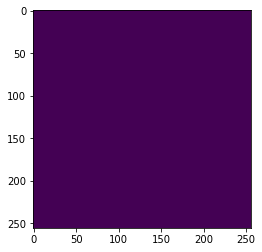

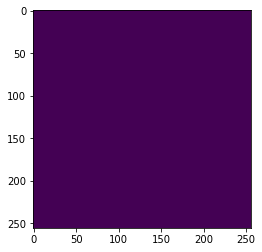

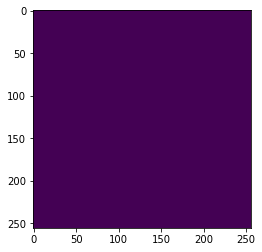

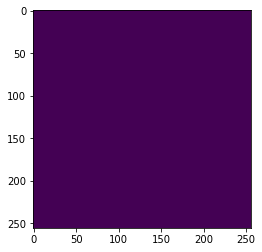

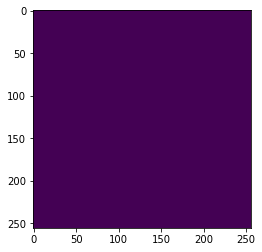

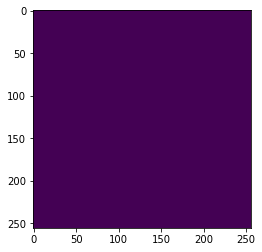

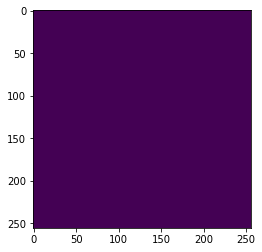

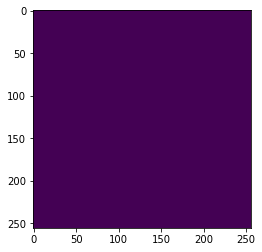

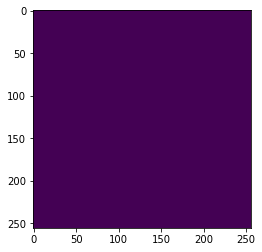

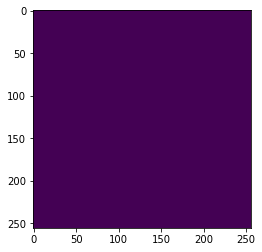

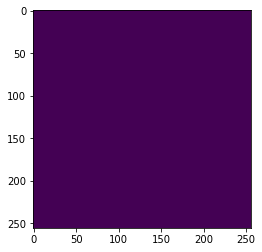

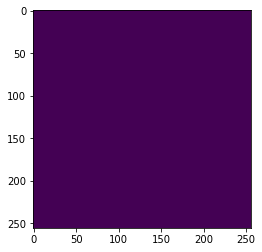

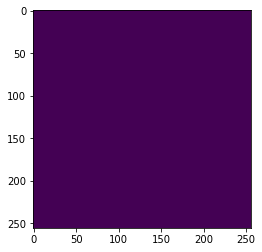

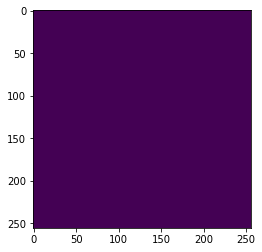

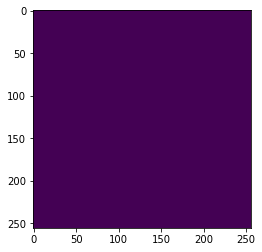

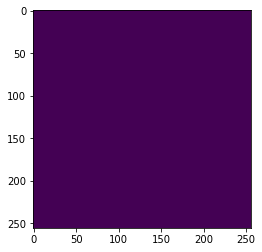

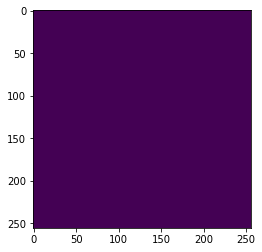

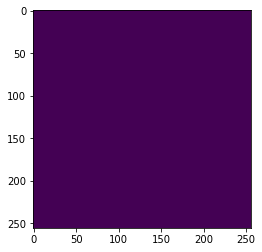

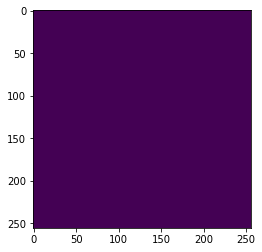

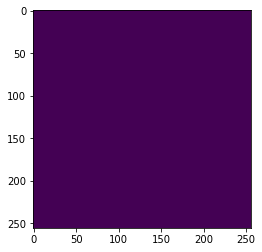

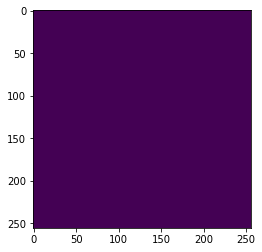

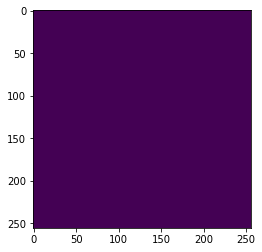

KeyboardInterrupt: 

In [18]:
ims = []
for i in range(len(r)):
    mat = np.zeros((256,256))
    x1 = int(r[i][0])//2
    y1 = int(r[i][1])//2
    x2 = int(r[i][2])//2
    y2 = int(r[i][3])//2
    mat[y1:y2,x1:x2] = 1
    plt.imshow(mat)
    plt.show()

In [6]:
def has_duplicates2(seq):
    seen = []
    unique_list = [x for x in seq if x not in seen and not seen.append(x)]
    return len(seq) != len(unique_list)

In [7]:
has_duplicates2(rois.cpu().detach().numpy().tolist())

True

In [8]:
from utils.utils import Anchors

In [9]:
x = Anchors()

In [15]:
mat=torch.rand((1,3,608,1024))

In [16]:
x(mat)

tensor([[[ -18.6274,   -7.3137,   26.6274,   15.3137],
         [ -24.5088,  -10.2544,   32.5088,   18.2544],
         [ -31.9188,  -13.9594,   39.9188,   21.9594],
         ...,
         [ 778.9807,  213.9613, 1141.0193,  938.0387],
         [ 731.9299,  119.8599, 1188.0701, 1032.1401],
         [ 672.6497,    1.2994, 1247.3503, 1150.7006]]], device='cuda:0')

In [15]:
def generate_anchors_single_pyramid(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # # Reshape to get a list of (y, x) and a list of (h, w)
    # box_centers = np.stack(
    #     [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    # box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # NOTE: the original order is  (y, x), we changed it to (x, y) for our code
    # Reshape to get a list of (x, y) and a list of (w, h)
    box_centers = np.stack(
        [box_centers_x, box_centers_y], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_widths, box_heights], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (x1, y1, x2, y2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

In [16]:
boxes = generate_anchors_single_pyramid(512, [0.5,1,2], [16,16], 128, 1)

In [17]:
boxes

array([[-181.01933598, -362.03867197,  181.01933598,  362.03867197],
       [-256.        , -256.        ,  256.        ,  256.        ],
       [-362.03867197, -181.01933598,  362.03867197,  181.01933598],
       ...,
       [1738.98066402, 1557.96132803, 2101.01933598, 2282.03867197],
       [1664.        , 1664.        , 2176.        , 2176.        ],
       [1557.96132803, 1738.98066402, 2282.03867197, 2101.01933598]])

In [13]:
x = torch.randn((2,100))
y = x>0.5

In [14]:
x[y]

tensor([1.1071, 2.3535, 1.3975, 0.9786, 0.7448, 1.7142, 1.8409, 0.9830, 1.4752,
        1.7743, 0.8599, 1.3342, 1.8738, 0.7444, 0.7069, 1.0174, 0.9728, 0.8374,
        0.9009, 0.5101, 0.5528, 0.5838, 0.5904, 0.7805, 0.6479, 1.2216, 1.3267,
        1.0994, 1.4495, 0.5088, 1.1427, 1.8168, 1.5460, 1.4135, 0.7165, 0.8006,
        0.7293, 1.6794, 1.7023, 0.5332, 2.1592, 1.5186, 0.9928, 1.3240, 0.6488,
        0.5804, 3.0967, 0.6649, 1.4805, 0.5530, 0.7309, 1.9717, 1.6999, 1.3094,
        0.7619, 1.9776, 0.6549, 0.7412, 0.7061, 2.1720])